# Benchmarking runtime and memory of annotation methods

This example benrchmarks runtime and memory requirements for annotating different datasets with different methods. The datasets are are taken from (Weinreb et al.) and (Avraham-Davidi et al.) or simulated using (Moriel) and (Kotliar).

(Weinreb et al.): Weinreb C, Rodriguez-Fraticelli A, Camargo FD, Klein AM. Lineage tracing on transcriptional landscapes links state to fate during differentiation. Science. 2020 Feb 14;367(6479):eaaw3381. doi: 10.1126/science.aaw3381. Epub 2020 Jan 23. PMID: 31974159; PMCID: PMC7608074.

(Avraham-Davidi et al.): Avraham-Davidi I, Mages S, Klughammer J, et al. Integrative single cell and spatial transcriptomics of colorectal cancer reveals multicellular functional units that support tumor progression. doi: https://doi.org/10.1101/2022.10.02.508492

(Moriel): Moriel, N. Extension of scsim single-cell RNA-sequencing data simulations. github.com/nitzanlab/scsim-ext (2023)

(Kotliar): Kotliar, D. scsim: simulate single-cell RNA-SEQ data using the Splatter statistical framework but implemented in python. github.com/dylkot/scsim (2021)

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import tacco as tc

# The notebook expects to be executed either in the workflow directory or in the repository root folder...
sys.path.insert(1, os.path.abspath('workflow' if os.path.exists('workflow/common_code.py') else '..')) 
import common_code

## Plotting setup

In [2]:
axsize = np.array([4,3])*0.5

def plot_benchmark_results(res, purpose):

    res['dataset'] = res['dataset'].astype(pd.CategoricalDtype(['Mixture','Dropout','Differentiation'], ordered=True))
    res = res.sort_values(['dataset','Ndat'])
    
    res['time (s)'] = res['annotation_time_s']
    res['memory (GB)'] = res['max_mem_usage_GB']
    res['L2 error'] = res['L2']
    
    methods = res['method'].unique()
    n_dnames = len(res['dataset'].unique())
    
    quantities = ['time (s)','memory (GB)','L2 error']
    fig,axs = tc.pl.subplots(n_dnames,len(quantities), axsize=axsize, x_padding=0.7, y_padding=0.5)
    colors = {m:common_code.method_color(m) for m in methods}
    styles = {m:common_code.method_style(m) for m in methods}
    for jx_ax, (dname, res1) in enumerate(res.groupby('dataset')):
        res1 = res1.loc[~res1[quantities].isna().all(axis=1)]
        for iy_ax, qty in enumerate(quantities):
            ax = axs[iy_ax,jx_ax]

            x = res1['Ndat']
            y = res1[qty]

            if qty == 'time (s)': # part 1 of adding second, minute and hour marker: plot the lines under the data

                ynew = np.array([0.1,1,10,60,600,3600,36000])
                ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,60,10),np.arange(60,600,60),np.arange(600,3600,600),np.arange(3600,36000,3600)]).flatten()
                ynewlabels = np.array(['0.1s','1s','10s','1min','10min','1h','10h'])
                if purpose == 'cross_methods':
                    ymin, ymax = 9, 44000
                else:
                    ymin, ymax = 3, 3600
                ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
                ynew = ynew[(ynew > ymin) & (ynew < ymax)]
                ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
                for yn in ynew:
                    ax.axhline(yn, color='gray', linewidth=0.5)

            elif qty == 'memory (GB)':

                ynew = np.array([0.1,0.4,1,4,10,40,100])
                ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100)]).flatten()
                ynewlabels = np.array(['0.1GB','0.4GB','1GB','4GB','10GB','40GB','100GB'])
                ymin, ymax = 0.7, 101
                ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
                ynew = ynew[(ynew > ymin) & (ynew < ymax)]
                ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
                for yn in ynew:
                    ax.axhline(yn, color='gray', linewidth=0.5)

            for m in methods:
                selector = res1['method'] == m
                if selector.sum() == 0:
                    continue
                zorder_args = {}
                if purpose != 'cross_methods' and m == 'TACCO':
                    zorder_args['zorder'] = 2.5
                ax.plot(x[selector],y[selector],marker='o',color=colors[m],ls=styles[m],label=m, **zorder_args)
            if iy_ax == 0:
                ax.set_title(f'{dname}')
            elif iy_ax == axs.shape[0] - 1:
                ax.set_xlabel('number of observations')
            if jx_ax == 0:
                if qty == 'time (s)':
                    ax.set_ylabel('runtime')
                elif qty == 'memory (GB)':
                    ax.set_ylabel('memory')
                else:
                    ax.set_ylabel(f'{qty}')
            if qty in ['time (s)','memory (GB)']:
                ax.set_yscale('log')
            ax.set_xscale('log')

            if qty in ['time (s)','memory (GB)']: # part 2 off adding second, minute and hour marker: add the second y axis after rescaling the first y axis to log scale
                ax.set_yticks(ynew_minor,minor=True)
                ax.set_yticks(ynew)
                ax.set_yticklabels(ynewlabels)
                ax.set_yticklabels([],minor=True)
                ax.set_ylim((ymin,ymax))

            if iy_ax == 0 and jx_ax == axs.shape[1] - 1:
                ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

## Cross method comparison

### Load results

Running all the methods on all datasets across all problem sizes takes quit a while and is therefore outsourced to the Snakemake workflow.

In [3]:
results_path = common_code.find_path('results/benchmarking')
cross_method_results = pd.read_csv(f'{results_path}/cross_methods.csv', index_col=0)

### Plot results

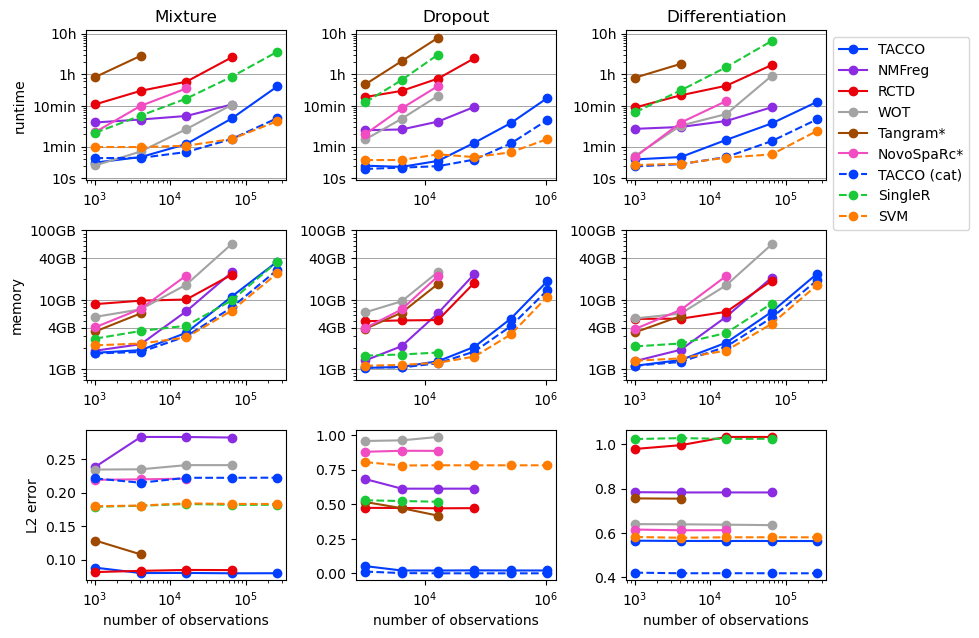

In [4]:
plot_benchmark_results(cross_method_results, purpose='cross_methods')

## Cross parameter comparison

### Load results

Running all parameter variations on all datasets across all problem sizes takes quit a while and is therefore outsourced to the Snakemake workflow.

In [5]:
results_path = common_code.find_path('results/benchmarking')
cross_params_results = pd.read_csv(f'{results_path}/cross_params.csv', index_col=0)

### Plot results

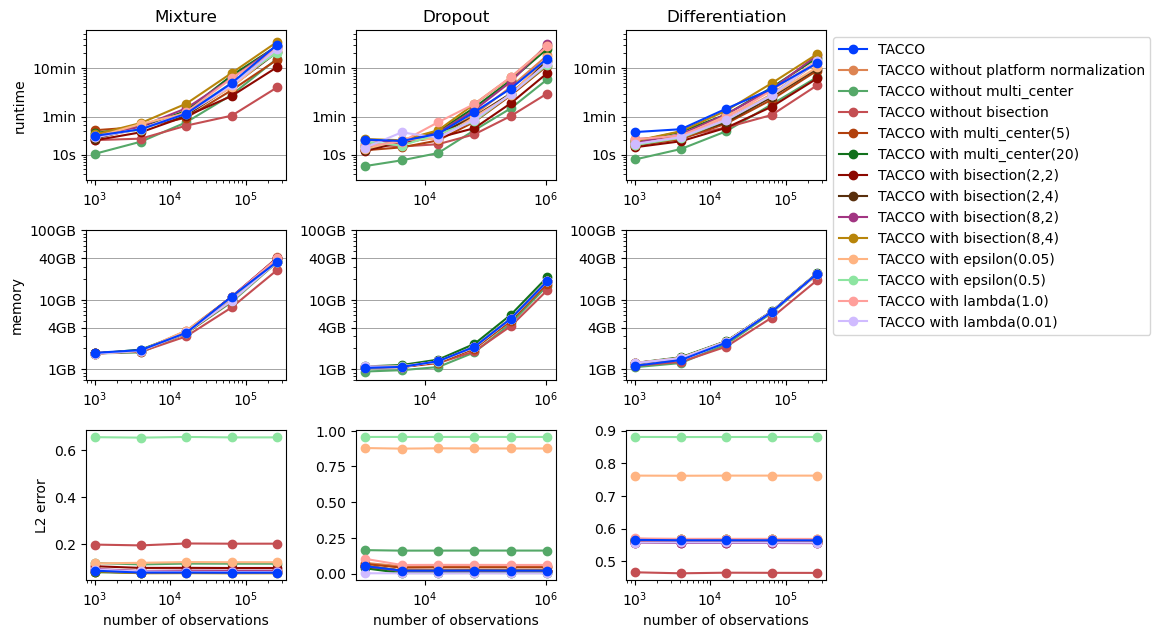

In [6]:
plot_benchmark_results(cross_params_results, purpose='cross_params')